# Spatial Mappings of Broadband Access in Oklahoma

Goal: Computationally determine geographic clustering (adjacency) of census tracts with similar levels of 10x1 internet speed adoption using graph theoretic methods.  

There currently exists no publicly available graph datasets that map adjacency between census tracts.  As such, a graph dataset will need to be created from scratch.  For the purposes of this endeavor, the census tracts from the state of Oklahoma will be used, and a graph $G = (V,E)$ where $V$ is the set of all census tracts in the state of Oklahoma and $E$ is the set of all edges representing adjacency between census tracts (an edge would be drawn between 2 vertices/nodes representing census tracts if the tracts share a border) will be generated.

In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import networkx as nx
import cendas as cd
import geopandas as gpd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/form-477-1218/tract_map_dec_2018.csv
/kaggle/input/tractshapefile/cb_2018_40_tract_500k.shp.iso.xml
/kaggle/input/tractshapefile/cb_2018_40_tract_500k.shp
/kaggle/input/tractshapefile/cb_2018_40_tract_500k.dbf
/kaggle/input/tractshapefile/cb_2018_40_tract_500k.shp.ea.iso.xml
/kaggle/input/tractshapefile/cb_2018_40_tract_500k.prj
/kaggle/input/tractshapefile/cb_2018_40_tract_500k.shx
/kaggle/input/tractshapefile/cb_2018_40_tract_500k.cpg


Imported relevant packages. 

In [3]:
census_tracts = cd.read_csv('../input/form-477-1218/tract_map_dec_2018.csv')
census_tracts = cd.state_column(census_tracts,'tractcode')
census_tracts = cd.conus_only(census_tracts,'tractcode')
#def recode(number):
    #if (number == 4) | (number == 5):
        #return 'High'
    #elif number == 3:
        #return 'Medium'
    #elif (number == 0) | (number == 1)| (number == 2):
        #return 'Low'
#census_tracts['10x1 Adoption'] = census_tracts['pcat_10x1'].apply(recode)
census_tracts_oklahoma = census_tracts[census_tracts['State'] == 'Oklahoma']
census_tracts_oklahoma = census_tracts_oklahoma.reset_index()
nodes_list = []
for i in census_tracts_oklahoma['tractcode']:
    index = census_tracts_oklahoma.index[census_tracts_oklahoma['tractcode'] == i]
    index = index.tolist()
    index = index[0]
    nodes_list.append((i, {'adoption': census_tracts_oklahoma['pcat_10x1'][index]}))
census_tracts_oklahoma

,index,tractcode,pcat_all,pcat_10x1,State,State Initials
0,53217,40001376600,2,1,Oklahoma,OK
1,53218,40001376700,2,1,Oklahoma,OK
2,53219,40001376800,1,1,Oklahoma,OK
3,53220,40001376900,4,2,Oklahoma,OK
4,53221,40001377000,2,2,Oklahoma,OK
...,...,...,...,...,...,...
1041,54258,40153953100,4,1,Oklahoma,OK
1042,54259,40153953200,2,1,Oklahoma,OK
1043,54260,40153953300,4,3,Oklahoma,OK
1044,54261,40153953400,4,3,Oklahoma,OK


Used FCC Form 477 data from December 2018 to generate vertices nodes for graph $G$.  Data from the 'pcat_10x1' column was used to assign node attributes.

In [4]:
oklahomadf = gpd.read_file('../input/tractshapefile/cb_2018_40_tract_500k.shp')
oklahomadf["NEIGHBORS"] = None 

for index, tract in oklahomadf.iterrows():   
    neighbors = oklahomadf[~oklahomadf.geometry.disjoint(tract.geometry)].GEOID.tolist()
    neighbors = [name for name in neighbors if tract.GEOID != name ]
    oklahomadf.at[index, "NEIGHBORS"] = ", ".join(neighbors)
oklahomadf = oklahomadf[['GEOID', 'NEIGHBORS']]
oklahomadf
    

,GEOID,NEIGHBORS
0,40065968800,"40065968100, 40065968700, 40065968500, 4006596..."
1,40071000201,"40071000202, 40071000500, 40071000100, 4007100..."
2,40073958100,"40073958200, 40083600700, 40083600800, 4001195..."
3,40079040500,"40079040602, 40079040302, 40079040301, 4007904..."
4,40079040602,"40079040500, 40079040302, 40079040601, 4007904..."
...,...,...
1041,40109108307,"40109108404, 40109108506, 40109108314, 4010910..."
1042,40027201610,"40027201801, 40027201609, 40027201607, 4002720..."
1043,40107080900,40107080600
1044,40143005300,"40143003800, 40143004000, 40143003700, 4014300..."


Parsed ArcGIS shapefiles for census tracts in Oklahoma (source: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html) using geopandas to determine neighboring census tracts for every census tract in Oklahoma (found code here: https://gis.stackexchange.com/questions/281652/find-all-neighbors-using-geopandas/281676).

In [5]:
edges=[]

for neighbor in oklahomadf['NEIGHBORS']:
    index = oklahomadf.index[oklahomadf['NEIGHBORS'] == neighbor]
    index = index.tolist()
    index = index[0]
    neighbor = neighbor.split(', ')
    for tract in neighbor:
        edges.append((oklahomadf['GEOID'][index], tract))

Iterated through the lists of neighbors to create edges between the vertices.  It is true that this approach creates redundancy by creating multiple duplicate edges.  With that said, Networkx does not duplicate edges when generating graphs, which renders this problem moot. 

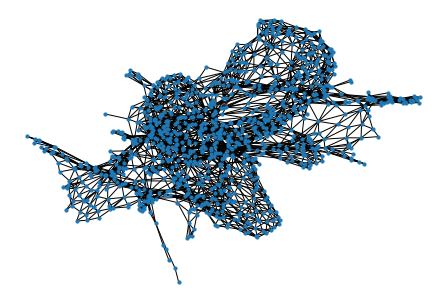

In [6]:
G = nx.Graph()
G.add_edges_from(edges)
G.add_nodes_from(nodes_list)
nx.draw(G, with_labels=False, node_size=10)

Generated graph $G = (V,E)$ where $V$ is the set of all census tracts in the state of Oklahoma and $E$ is the set of all edges representing adjacency between census tracts.

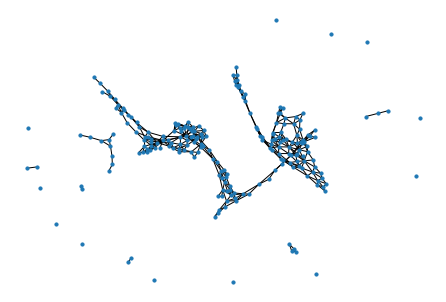

In [7]:
selected_nodes = [n for n,v in G.nodes(data=True) if v['adoption'] == 5]
H = G.subgraph(selected_nodes)
nx.draw(H, with_labels = False, node_size=10)

Generated subgraph $H$ for all vertices with 10x1 adoption levels are equal to 5 where $V(H) \subseteq V(G)$ and $E(H) \subseteq E(G)$. 10x1 adoption levels indicated at 5 indicate $800 < x$ residential connections per 1000 housesholds.  Edge atrtibutes from graph $G$ are maintained for the generation of these subgraphs.

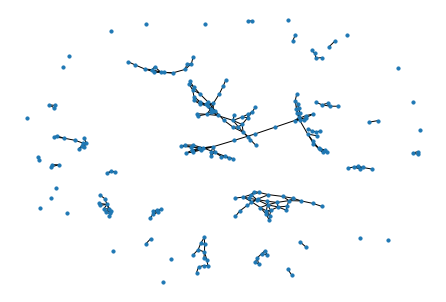

In [8]:
selected_nodes = [n for n,v in G.nodes(data=True) if v['adoption'] == 4]
I = G.subgraph(selected_nodes)
nx.draw(I, with_labels = False, node_size=10)

Generated subgraph $I$ for all vertices with 10x1 adoption levels are equal to 5 where $V(I) \subseteq V(G)$ and $E(I) \subseteq E(G)$. 10x1 adoption levels indicated at 4 indicate $600< x \leq 800$ residential connections per 1000 housesholds.

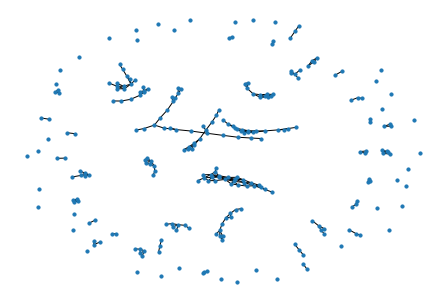

In [9]:
selected_nodes = [n for n,v in G.nodes(data=True) if v['adoption'] == 3]
J = G.subgraph(selected_nodes)
nx.draw(J, with_labels = False, node_size=10)

Generated subgraph $J$ for all vertices with 10x1 adoption levels are equal to 5 where $V(J) \subseteq V(G)$ and $E(J) \subseteq E(G)$. 10x1 adoption levels indicated at 3 indicate $400< x \leq 600$ residential connections per 1000 housesholds.

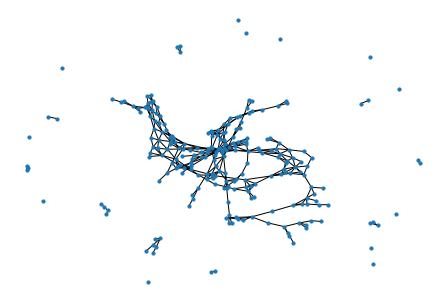

In [10]:
selected_nodes = [n for n,v in G.nodes(data=True) if v['adoption'] == 2]
K = G.subgraph(selected_nodes)
nx.draw(K, with_labels = False, node_size=10)

Generated subgraph $K$ for all vertices with 10x1 adoption levels are equal to 5 where $V(K) \subseteq V(G)$ and $E(K) \subseteq E(G)$. 10x1 adoption levels indicated at 2 indicate $200 < x \leq 400$ residential connections per 1000 housesholds.

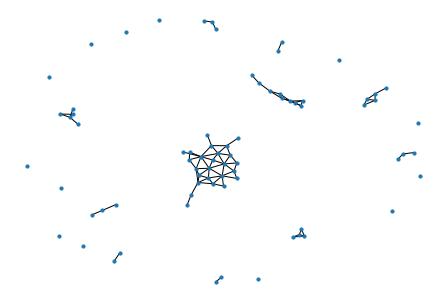

In [11]:
selected_nodes = [n for n,v in G.nodes(data=True) if v['adoption'] == 1]
L = G.subgraph(selected_nodes)
nx.draw(L, with_labels = False, node_size=10)

Generated subgraph $L$ for all vertices with 10x1 adoption levels are equal to 5 where $V(L) \subseteq V(G)$ and $E(K) \subseteq E(L)$. 10x1 adoption levels indicated at 1 indicate $0 < x \leq 200$ residential connections per 1000 housesholds.


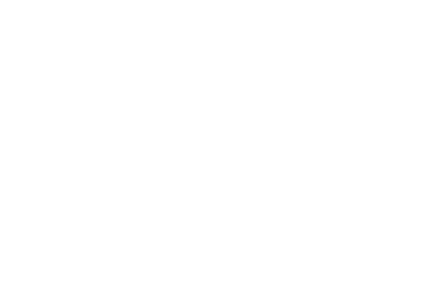

In [12]:
selected_nodes = [n for n,v in G.nodes(data=True) if v['adoption'] == 0]
M = G.subgraph(selected_nodes)
nx.draw(M, with_labels = False, node_size=10)

Generated subgraph $M$ for all vertices with 10x1 adoption levels are equal to 5 where $V(M) \subseteq V(G)$ and $E(M) \subseteq E(L)$. 10x1 adoption levels indicated at 0 indicate 0 residential connections per 1000 housesholds.  It is evident that $V(M), E(M) = \emptyset$, as there are no vertices with 10x1 adoption levels at 0.

Conclusion: It is visually evident that there is at least some degree of spatial clustering of census tracts with similar level of 10X1 internet speed adoption.  A graph theoretic approach allows for us to computationally evaluate this instead of eyeballing a map.